# Exploratory Data Analysis (EDA) – Flu Prediction Project

### Objective

This notebook presents the exploratory data analysis (EDA) for our project on flu hospitalization prediction in Rochester, New-York. Our goal is to understand the relationships between influenza hospitalization rates and environmental as well as temporal variables.

### Focus of This Notebook

We focus exclusively on exploring and visualizing the data in order to:
- Identify seasonal patterns and age/virus-related disparities in flu hospitalization
- Assess the distribution of weather variables and their intercorrelations
- Investigate initial associations between weather features and flu activity
- Provide insights that will guide feature selection and modeling choices in the next stage

### Data Sources
We work with two primary datasets:
- **Influenza Surveillance Data:** Contains weekly flu activity in US, including rates across age categories and virus types (filtered on Rochester, NY).
- **Climate Data (gridMET):** Provides weekly meteorological data such as temperature, humidity, wind speed, and precipitation.

# Data Loading, Preparation & Cleaning

We start by preparing the influenza and weather datasets to ensure alignment on a weekly temporal basis.

- The flu dataset (`df_flu`) includes weekly influenza-like illness (ILI) rates by age group and virus type. 
- The weather dataset (`df_weather`) contains daily meteorological variables, which we aggregate to a weekly level by aligning all dates to Mondays.

**Key Steps:**
- Convert flu dates using `YEAR` and `WEEK` into a proper datetime format.
- Align weather `time` values to the beginning of the week (Monday).
- Perform a **left join** on the `date` column to merge flu and weather data.
- Keep only relevant columns in the flu dataset (`AGE CATEGORY`, `VIRUS TYPE CATEGORY`, `date`, and `WEEKLY RATE`).
- Drop all rows with missing values in the weather data **but keep rows with missing `WEEKLY RATE`** (our target), as we may want to impute or discard them later.

This ensures that our dataset is consistent, aligned temporally, and free of rows with missing predictors.

#### Data Loading

In [1]:
# Import libraries
import pandas as pd
import numpy as np

# Load flu and weather datasets
df_flu = pd.read_csv("data/rochester.csv", sep=",")
df_weather = pd.read_csv("data/gridmet.csv")

In [2]:
df_flu.head()

,CATCHMENT,NETWORK,YEAR,YEAR.1,WEEK,AGE CATEGORY,SEX CATEGORY,RACE CATEGORY,VIRUS TYPE CATEGORY,CUMULATIVE RATE,WEEKLY RATE,AGE ADJUSTED CUMULATIVE RATE,AGE ADJUSTED WEEKLY RATE
0,New York - Rochester,EIP,2015-16,2015,40,Overall,Female,Overall,Overall,0.0,0.0,NaN,NaN
1,New York - Rochester,EIP,2015-16,2015,40,Overall,Male,Overall,Overall,0.0,0.0,NaN,NaN
2,New York - Rochester,EIP,2015-16,2015,40,Overall,Overall,White,Overall,0.0,0.0,NaN,NaN
3,New York - Rochester,EIP,2015-16,2015,40,Overall,Overall,Black,Overall,0.0,0.0,NaN,NaN
4,New York - Rochester,EIP,2015-16,2015,40,Overall,Overall,Hispanic/Latino,Overall,0.0,0.0,NaN,NaN


#### Data Cleaning

In [3]:
# Drop unnecessary columns from df_flu
df_flu = df_flu.drop(columns=["YEAR", "CUMULATIVE RATE"])
# Rename columns for clarity
df_flu = df_flu.rename(columns={"YEAR.1": "YEAR"})

df_flu.head()

# Check and convert date formats if needed
df_flu["date"] = pd.to_datetime(df_flu["YEAR"].astype(str) + "-W" + df_flu["WEEK"].astype(str) + "-1", format="%Y-W%W-%w")
df_weather["time"] = pd.to_datetime(df_weather["time"], errors='coerce')  # Convert 'time' to datetime
df_weather["date"] = df_weather["time"] + pd.offsets.Week(weekday=0)  # Align to Monday

# Filter df_flu to keep only 'Overall' values for Race and Sex categories
df_flu = df_flu[(df_flu["RACE CATEGORY"] == "Overall") & (df_flu["SEX CATEGORY"] == "Overall")]

# Filter df_flu on relevant columns only
df_flu = df_flu[["AGE CATEGORY", "VIRUS TYPE CATEGORY", "date", "WEEKLY RATE"]]

# Merge flu and weather data on date
df_merged = pd.merge(df_flu, df_weather, on="date", how="left")

# Drop missing values
df_merged = df_merged.dropna().reset_index(drop=True)

# Display preview
df_merged.head()

,AGE CATEGORY,VIRUS TYPE CATEGORY,date,WEEKLY RATE,time,air_temperature,burning_index_g,dead_fuel_moisture_1000hr,dead_fuel_moisture_100hr,mean_vapor_pressure_deficit,potential_evapotranspiration,precipitation_amount,relative_humidity,specific_humidity,surface_downwelling_shortwave_flux_in_air,wind_from_direction,wind_speed
0,Overall,Overall,2015-10-05,0.0,2015-10-04,288.69287,40.958332,19.141668,18.447023,0.354048,19.770834,43.920837,64.08869,0.007649,127.9512,115.64285,6.190476
1,Overall,Influenza B,2015-10-05,0.0,2015-10-04,288.69287,40.958332,19.141668,18.447023,0.354048,19.770834,43.920837,64.08869,0.007649,127.9512,115.64285,6.190476
2,Overall,Influenza A,2015-10-05,0.0,2015-10-04,288.69287,40.958332,19.141668,18.447023,0.354048,19.770834,43.920837,64.08869,0.007649,127.9512,115.64285,6.190476
3,Overall,Overall,2015-10-05,0.1,2015-10-04,288.69287,40.958332,19.141668,18.447023,0.354048,19.770834,43.920837,64.08869,0.007649,127.9512,115.64285,6.190476
4,Overall,Influenza A,2015-10-05,0.1,2015-10-04,288.69287,40.958332,19.141668,18.447023,0.354048,19.770834,43.920837,64.08869,0.007649,127.9512,115.64285,6.190476


# Exploratory Data Analysis (EDA)

**Analysis Scope**

In the following sections, we dive into the core dimensions of the dataset to uncover meaningful patterns prior to modeling. We aim to answer questions such as:
- How does the weekly flu hospitalization rate evolve over time?
- Are there visible seasonal or demographic trends?
- How are weather variables distributed and interrelated?
- Do any environmental factors show early signs of association with flu activity?

**Important note:**
The dataset only covers flu season periods (typically October to April). Therefore, **all visualizations reflect in-season trends only**. Off-season data (May to September) is not available, which limits our ability to observe baseline hospitalization rates or detect anomalies outside of the flu season.

### Weekly Flu Rate Over Time

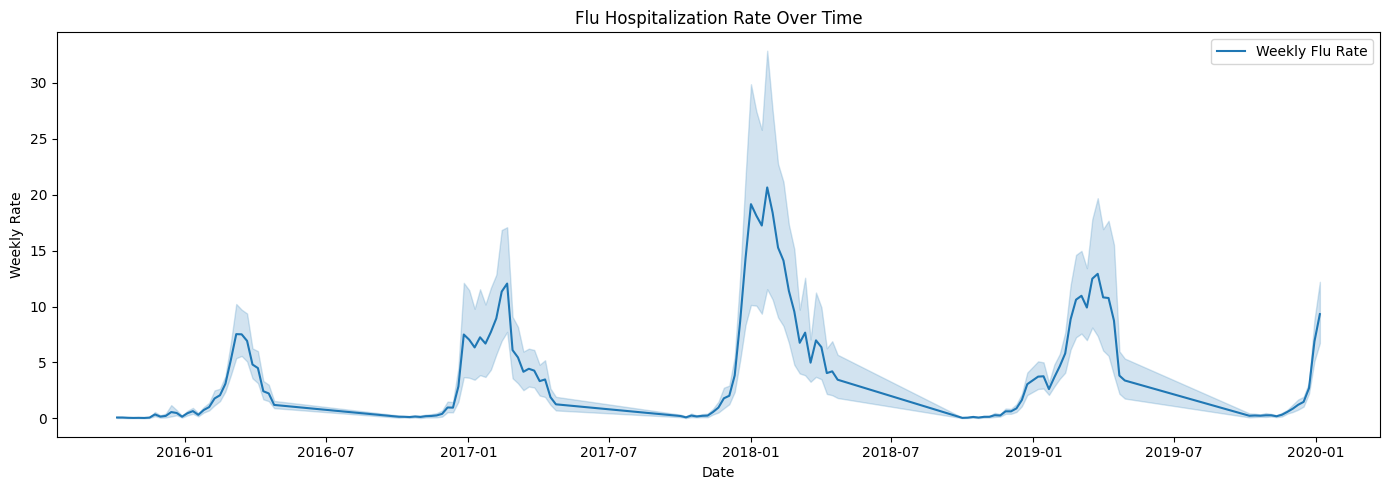

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 5))
sns.lineplot(data=df_merged, x='date', y='WEEKLY RATE', label='Weekly Flu Rate')
plt.title('Flu Hospitalization Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Weekly Rate')
plt.tight_layout()
plt.show()

This time series plot clearly highlights the **seasonal peaks of flu hospitalizations** between 2015 and 2020, with distinct surges typically occurring between late fall and early spring. Each spike reflects a flu season with varying intensity.

### Distribution of Weekly Rate

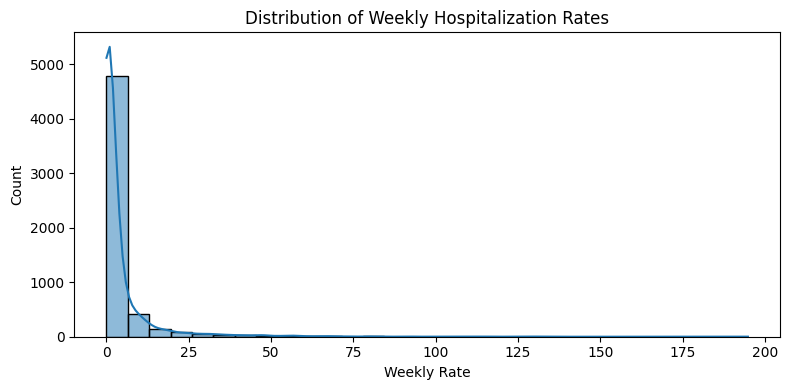

In [5]:
plt.figure(figsize=(8, 4))
sns.histplot(df_merged["WEEKLY RATE"], bins=30, kde=True)
plt.title("Distribution of Weekly Hospitalization Rates")
plt.xlabel("Weekly Rate")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

This histogram shows a **right-skewed distribution** of weekly hospitalization rates, with the majority of weeks reporting low flu activity (around 0–3 hospitalizations per 100,000). A long tail extends toward higher values, reflecting occasional flu peaks during intense seasons.

### Seasonal Trend (by Month)

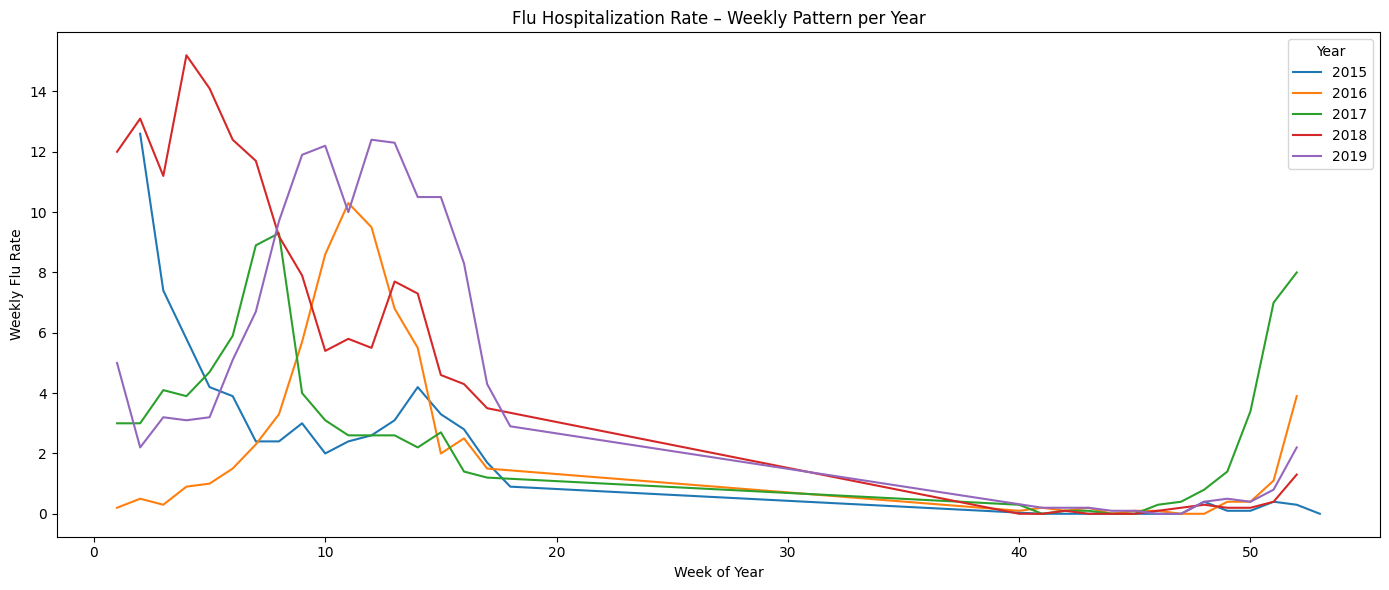

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Adding year and week of year columns
df_merged['year'] = df_merged['date'].dt.year
df_merged['weekofyear'] = df_merged['date'].dt.isocalendar().week

# Plot
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_merged, x='weekofyear', y='WEEKLY RATE', hue='year', palette='tab10')

plt.title('Flu Hospitalization Rate – Weekly Pattern per Year')
plt.xlabel('Week of Year')
plt.ylabel('Weekly Flu Rate')
plt.legend(title='Year')
plt.tight_layout()
plt.show()

This seasonal lineplot helps visualize the flu dynamics during Influenza-season across years.

### Distribution of Weather Variables

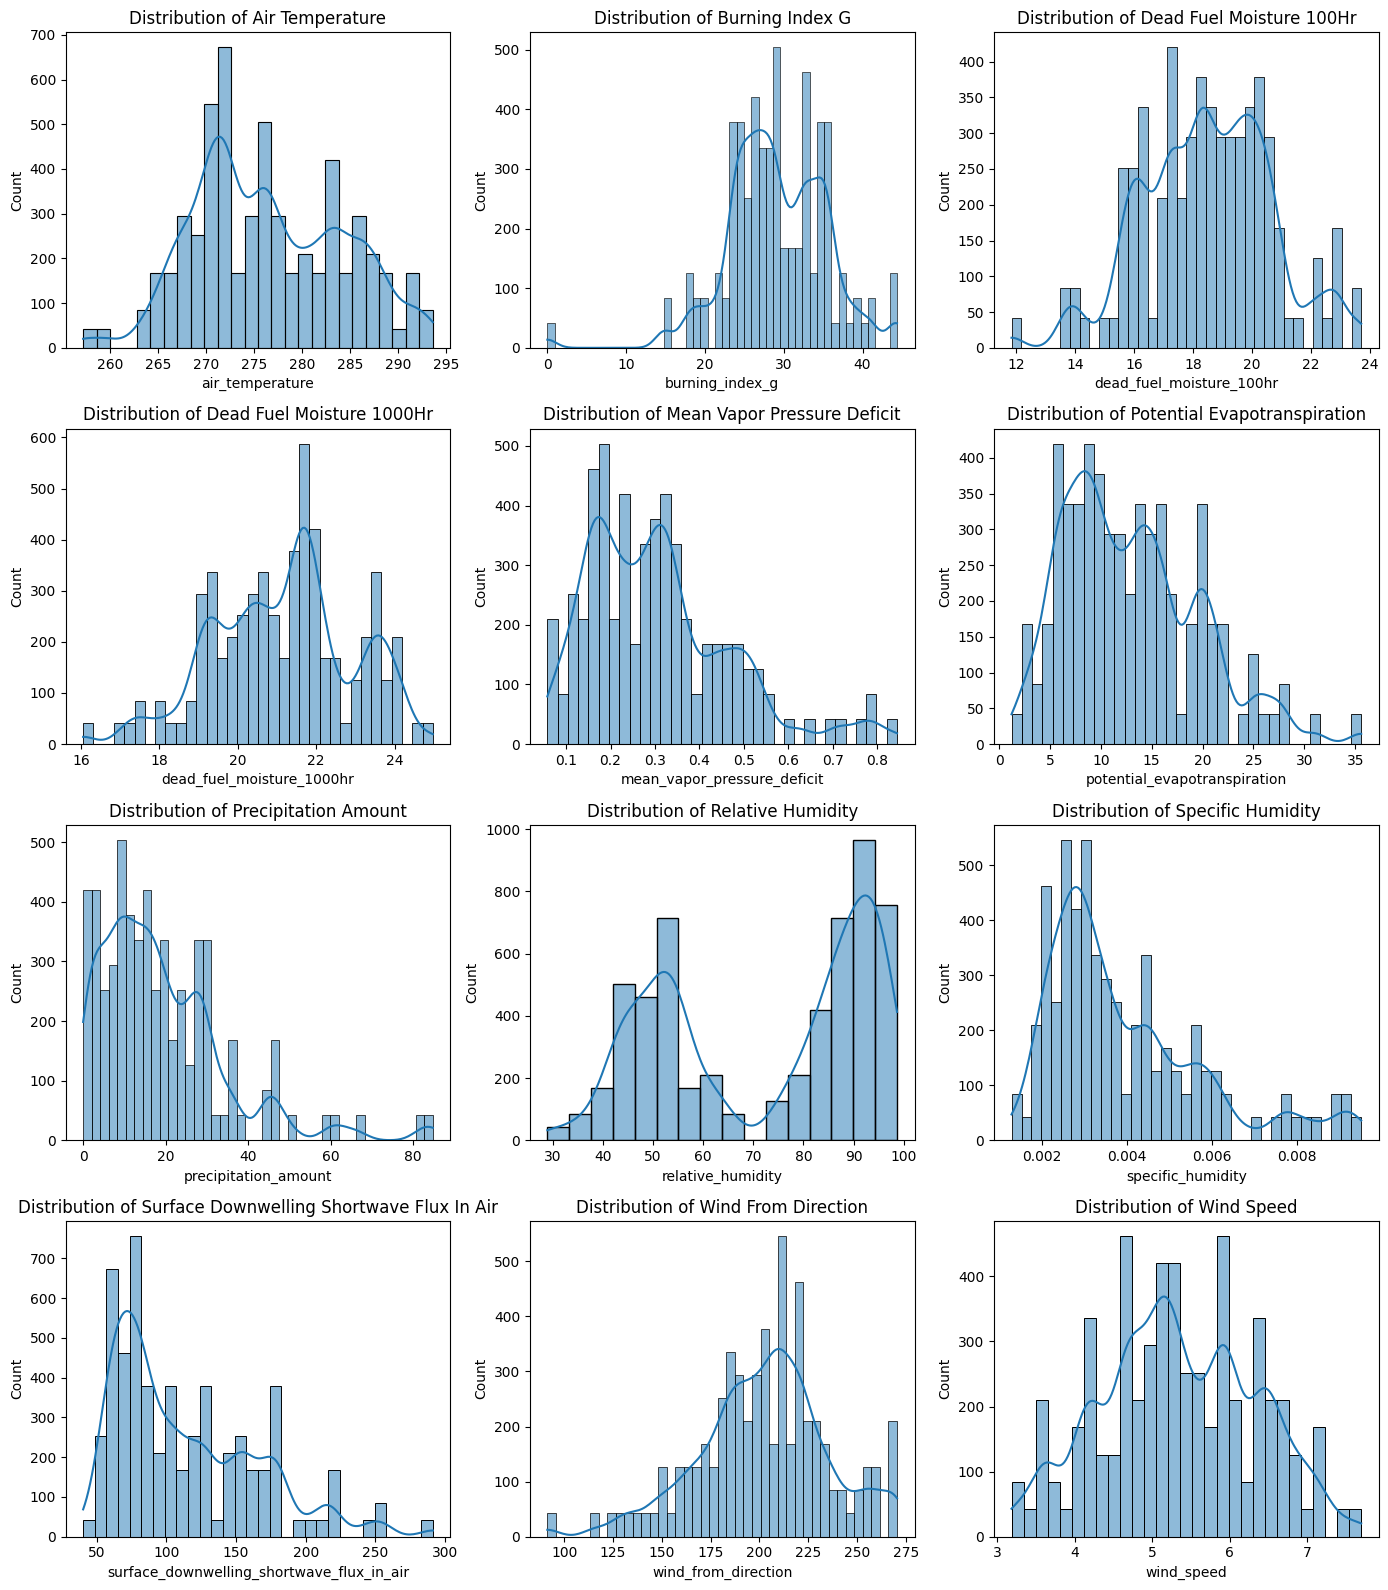

In [8]:
weather_vars = [
    'air_temperature',
    'burning_index_g',
    'dead_fuel_moisture_100hr',
    'dead_fuel_moisture_1000hr',
    'mean_vapor_pressure_deficit',
    'potential_evapotranspiration',
    'precipitation_amount',
    'relative_humidity',
    'specific_humidity',
    'surface_downwelling_shortwave_flux_in_air',
    'wind_from_direction',
    'wind_speed'
]

# Define the number of columns for the subplot grid
cols = 3  # You can adjust this value based on your preference

# Adjust the number of rows and columns for subplots based on the number of variables
rows = (len(weather_vars) + cols - 1) // cols  # Calculate rows dynamically
fig, axes = plt.subplots(rows, cols, figsize=(14, rows * 4))
axes = axes.flatten()

for i, var in enumerate(weather_vars):
    sns.histplot(df_merged[var], kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {var.replace('_', ' ').title()}")

# Hide unused axes
for j in range(len(weather_vars), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

These histograms provide an overview of the distribution of key climate variables in the dataset. Most variables show right-skewed patterns, especially precipitation and vapor pressure deficit, indicating frequent low values and occasional extremes. Others, like wind direction and specific humidity, appear more normally distributed. This helps identify potential outliers, supports feature scaling decisions, and highlights which variables may require transformation before modeling.

### Correlation Matrix (WEEKLY RATE + Weather)

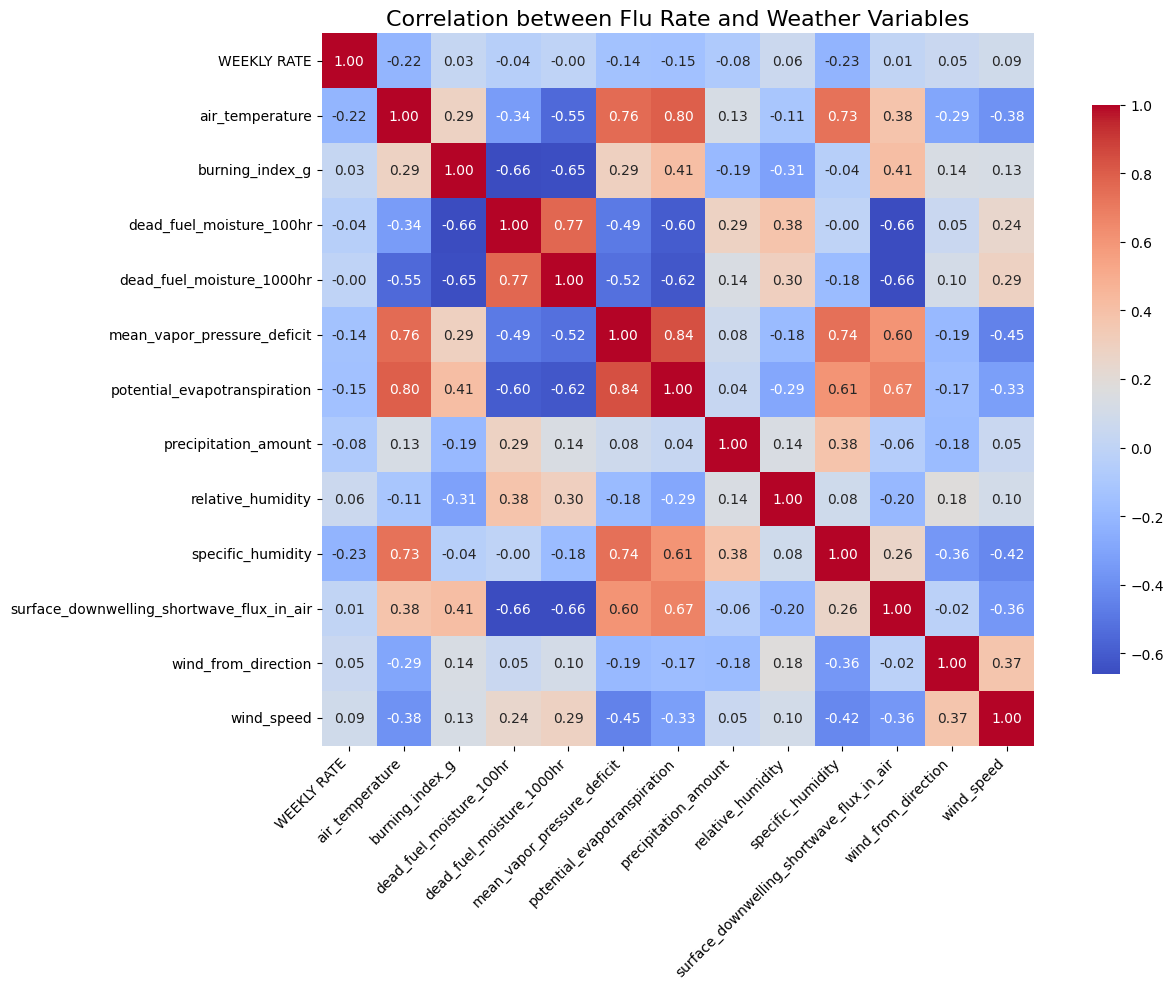

In [9]:
# Select relevant numeric columns
correlation_cols = ['WEEKLY RATE'] + weather_vars
corr = df_merged[correlation_cols].corr()


# Plot
plt.figure(figsize=(14, 10))
sns.heatmap(
    corr, 
    annot=True, 
    fmt=".2f", 
    cmap='coolwarm', 
    square=True, 
    cbar_kws={'shrink': 0.8},
    annot_kws={"size": 10}
)

plt.title("Correlation between Flu Rate and Weather Variables", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [12]:
# Compute correlation with 'WEEKLY RATE' only
correlations = df_merged[['WEEKLY RATE'] + weather_vars].corr()['WEEKLY RATE'].drop('WEEKLY RATE')

# Convert to DataFrame and sort by absolute value
correlation_table = correlations.to_frame().reset_index()
correlation_table.columns = ['Variable', 'Correlation with WEEKLY RATE']

# Sort by absolute correlation value (descending)
correlation_table['AbsCorr'] = correlation_table['Correlation with WEEKLY RATE'].abs()
correlation_table = correlation_table.sort_values(by='AbsCorr', ascending=False).drop(columns='AbsCorr')

# Display as a clean table
from IPython.display import display
display(correlation_table)

,Variable,Correlation with WEEKLY RATE
8,specific_humidity,-0.225635
0,air_temperature,-0.217129
5,potential_evapotranspiration,-0.146699
4,mean_vapor_pressure_deficit,-0.137583
11,wind_speed,0.088322
6,precipitation_amount,-0.077839
7,relative_humidity,0.064766
10,wind_from_direction,0.052094
2,dead_fuel_moisture_100hr,-0.038832
1,burning_index_g,0.030727


In [13]:
# Compute the full correlation matrix
corr_matrix = df_merged[weather_vars].corr()

# Convert the matrix to a long-form DataFrame
corr_pairs = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))  # upper triangle only
corr_pairs = corr_pairs.stack().reset_index()
corr_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']

# Add column for absolute correlation to sort
corr_pairs['AbsCorr'] = corr_pairs['Correlation'].abs()
corr_pairs = corr_pairs.sort_values(by='AbsCorr', ascending=False).drop(columns='AbsCorr')

pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns (just in case)
pd.set_option('display.width', 1000)  # Adjust width to avoid line breaks

# Display the top correlations
from IPython.display import display
display(corr_pairs)

,Variable 1,Variable 2,Correlation
38,mean_vapor_pressure_deficit,potential_evapotranspiration,0.840514
4,air_temperature,potential_evapotranspiration,0.796065
21,dead_fuel_moisture_100hr,dead_fuel_moisture_1000hr,0.771886
3,air_temperature,mean_vapor_pressure_deficit,0.756474
41,mean_vapor_pressure_deficit,specific_humidity,0.738012
7,air_temperature,specific_humidity,0.728644
48,potential_evapotranspiration,surface_downwelling_shortwave_flux_in_air,0.671978
35,dead_fuel_moisture_1000hr,surface_downwelling_shortwave_flux_in_air,-0.661594
11,burning_index_g,dead_fuel_moisture_100hr,-0.660567
27,dead_fuel_moisture_100hr,surface_downwelling_shortwave_flux_in_air,-0.660050


#### **Correlation Overview:**
The heatmap and correlation tables reveal that the flu hospitalization rate (WEEKLY RATE) shows very weak correlations with individual weather variables. The strongest absolute correlation is only -0.21 with potential evapotranspiration. This suggests that no single weather factor alone strongly explains flu hospitalization trends, which may indicate the need for multivariate or nonlinear modeling approaches.

However, the analysis also highlights strong intercorrelations among certain climate features, especially:

Mean Vapor Pressure Deficit is highly correlated with:
- Potential Evapotranspiration (r = 0.84)
- Dead Fuel Moisture 1000hr (r = 0.78)
- Air Temperature (r = 0.76)
- Specific Humidity (r = 0.74)

Air Temperature shows strong correlation with:
- Potential Evapotranspiration (r = 0.80)
- Specific Humidity (r = 0.73)

Potential Evapotranspiration is also strongly correlated with:
- Surface Downwelling Shortwave Flux in Air (r = 0.67)

These clusters of correlated variables suggest redundancy, which should be taken into account when selecting features for modeling (e.g., via dimensionality reduction or regularization techniques).


#### **Why This Matters for Our Business Case**
The weak correlation between weather and flu-specific hospitalizations suggests that climate alone is not a reliable predictor in this context.

**What does this mean for our model?**
- This insight helps manage expectations: relying solely on meteorological data to predict flu hospitalizations is unlikely to yield highly accurate predictions. Additional data sources (e.g., viral surveillance, mobility data, vaccination rates, or Google Trends) may be essential to improve performance.

**However, this doesn’t diminish the value of weather data.**
- The strong correlations observed between some weather features themselves suggest the presence of meaningful meteorological dynamics, which could be highly predictive of other weather-sensitive health outcomes (e.g., asthma, heatstroke/dehydration, respiratory distress, cardiovascular stress during heatwaves, wildfires, etc.).

**Strategic takeaway:**

Even if weather alone isn’t sufficient for influenza modeling, it could be extremely useful if:
- We expand the scope to general hospital admissions (not just flu)
- Or focus on climate-sensitive diseases, such as:
- Chronic respiratory illnesses (e.g. COPD exacerbations)
- Dehydration or cardiovascular cases during heat waves
- Air pollution-related hospitalizations
- Vector-borne diseases (in combination with mosquito population data)

### Weekly Rate by Age Group or Virus Type

In [14]:
df_merged['AGE CATEGORY'].unique()

array(['Overall', '0-4 yr', '5-17 yr', '18-49 yr', '50-64 yr', '>= 65 yr',
       '65-74 yr', '75-84 yr', '>= 85', '18-29 yr', '30-39 yr',
       '40-49 yr', '0-< 1 yr', '1-4 yr', '>= 75', '5-11  yr', '12-17 yr',
       '< 18', '>= 18'], dtype=object)

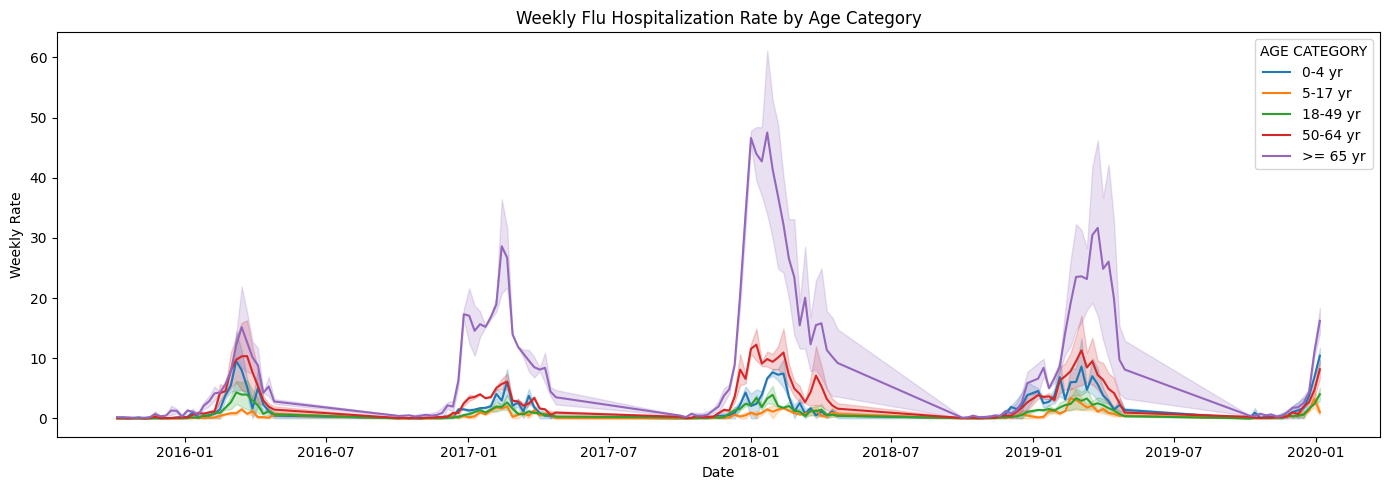

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# === AGE GROUPS OF INTEREST ===
# Define the selected age categories
selected_ages = ["0-4 yr", "5-17 yr", "18-49 yr", "50-64 yr", ">= 65 yr"]

# Create a filtered DataFrame
df_age = df_merged[df_merged["AGE CATEGORY"].isin(selected_ages)].copy()

plt.figure(figsize=(14, 5))
sns.lineplot(data=df_age, x="date", y="WEEKLY RATE", hue="AGE CATEGORY")
plt.title("Weekly Flu Hospitalization Rate by Age Category")
plt.xlabel("Date")
plt.ylabel("Weekly Rate")
plt.tight_layout()
plt.show()

The plot shows clear seasonal flu peaks each winter, with hospitalization rates varying significantly by age. **The ≥ 65 years group is consistently the most affected**, followed by 50–64 years. Children aged 0–4 years also show notable peaks, while 5–17 and 18–49 years remain relatively low. This highlights age as a major factor in flu severity.

Since hospitalization rates differ drastically by age, building age-specific models or adding age category as a feature could improve predictive performance.

**Key Insight: Public health services can prioritize elderly care during flu season** (e.g., ICU beds, vaccinations).

### Weekly Rate by Virus Type

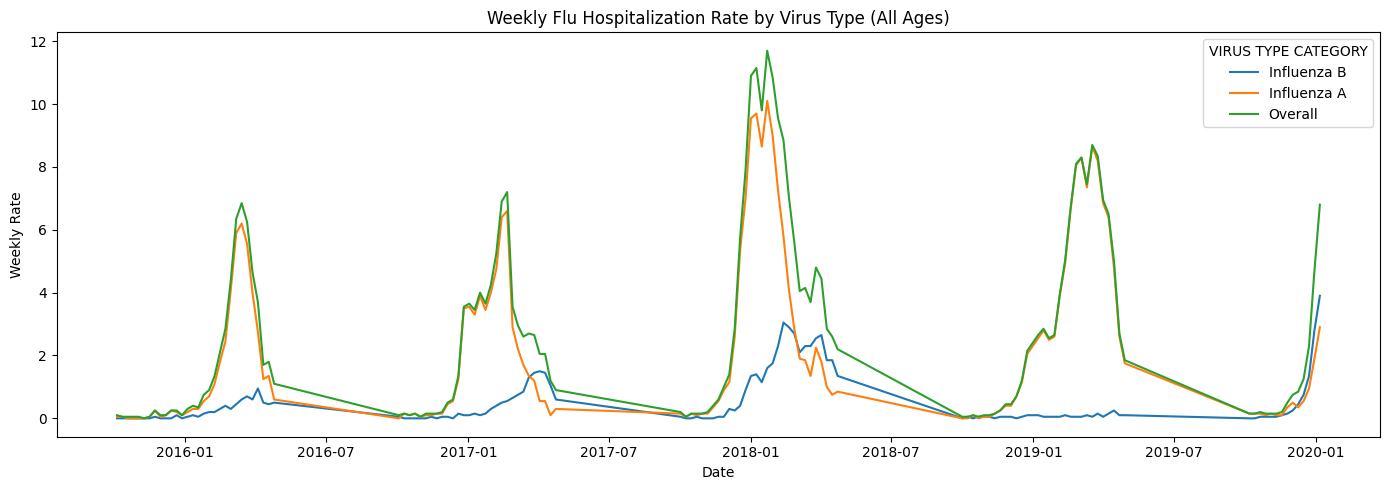

In [29]:
df_virus = df_merged[df_merged["AGE CATEGORY"] == "Overall"]

plt.figure(figsize=(14, 5))
sns.lineplot(data=df_virus, x="date", y="WEEKLY RATE", hue="VIRUS TYPE CATEGORY",errorbar=None)
plt.title("Weekly Flu Hospitalization Rate by Virus Type (All Ages)")
plt.xlabel("Date")
plt.ylabel("Weekly Rate")
plt.tight_layout()
plt.show()

This plot shows that Influenza A is the dominant contributor to hospitalization peaks across all seasons. Influenza B causes lower rates overall and often peaks later in the season. The “Overall” curve closely follows Influenza A, confirming its greater impact on hospital burden.

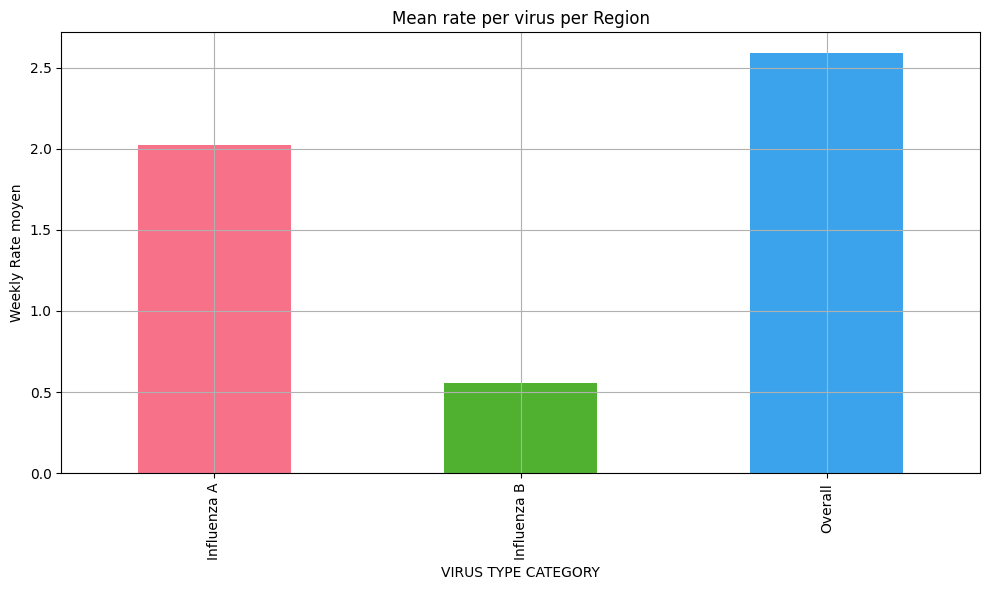

In [13]:
# Define colors for each virus type
colors = sns.color_palette("husl", df_virus["VIRUS TYPE CATEGORY"].nunique())

# Plot the bar chart with custom colors
df_virus.groupby("VIRUS TYPE CATEGORY")["WEEKLY RATE"].mean().plot(
    kind='bar', 
    figsize=(10, 6), 
    color=colors
)

plt.title("Mean rate per virus per Region")
plt.ylabel("Weekly Rate moyen")
plt.grid(True)
plt.tight_layout()
plt.show()

The mean weekly hospitalization rate for Influenza A is nearly four times higher than for Influenza B. This explains why the Overall rate in the time-series plot (green curve) closely follows the Influenza A rate (orange curve), highlighting Influenza A’s dominant role in overall flu burden during the period analyzed.

# Conclusion

This exploratory analysis reveals clear seasonal patterns in flu hospitalizations, with elderly populations (≥65) being the most affected. Influenza A is consistently the dominant virus type, driving most hospitalization spikes. While individual weather variables show only weak correlations with flu rates, strong intercorrelations among meteorological features suggest complex dynamics that may require multivariate or nonlinear modeling.

These insights highlight the importance of incorporating temporal patterns and carefully selecting or transforming environmental features in the modeling phase.